In [1]:
# Standard library imports
from argparse import ArgumentParser
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

# local application imports
from lag_caVAE.lag import Lag_Net
from lag_caVAE.nn_models import MLP_Encoder, MLP, MLP_Decoder, PSD
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform
from utils import arrange_data, from_pickle, my_collate, ImageDataset
from examples.acro_lag_cavae_trainer import Model

seed_everything(0)
%matplotlib inline
DPI = 600

## Load Model

In [2]:
# homo_u, bs 256, annealing
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'acro-lag-cavae-T_p=4-epoch=2801.ckpt')
model = Model.load_from_checkpoint(checkpoint_path)

## Prepare Data

In [3]:
data_path=os.path.join(PARENT_DIR, 'datasets', 'acrobot-gym-image-dataset-rgb-u9-test.pkl')
test_dataset = ImageDataset(data_path, 19, ctrl=False)

test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=my_collate)

In [4]:
test_batch = next(iter(test_dataloader))
X, u = test_batch

In [5]:
model.t_eval = torch.from_numpy(test_dataset.t_eval)
model.hparams.solver = 'rk4'
model(X, u)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


### Check learned link1 (single channel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


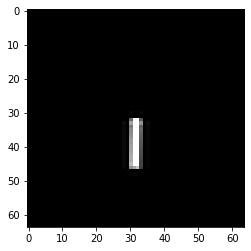

In [6]:
# link1
fig = plt.figure()
grid = utils.make_grid(model.link1[0].view(-1, 1, 64, 64), nrow = 5)
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

### check learned link2 (single channel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


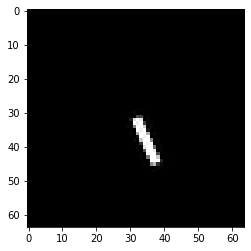

In [7]:
# pole
fig = plt.figure()
grid = utils.make_grid(model.link2[0].view(-1, 1, 64, 64), nrow = 5)
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

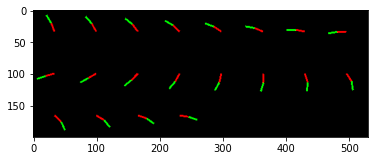

In [8]:
# data trajectory
b_ind = 0
grid = utils.make_grid(X[:, b_ind])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

### Note: it is impossible to make long term prediction since this is a chaotic system. Difference in the long term is EXPECTED

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


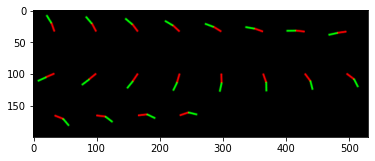

In [9]:
# prediction trajectory
grid = utils.make_grid(model.Xrec[:, b_ind])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

## check how learned potential energy varies with $\phi_1$
### plot learned potential energy

In [10]:
q1 = np.linspace(0, 2*np.pi, 41)
q2 = np.linspace(0, 0, 41)
cos_q1 = np.cos(q1[:-1]) ; cos_q2 = np.cos(q2[:-1])
sin_q1 = np.sin(q1[:-1]) ; sin_q2 = np.sin(q2[:-1])
cos_q_sin_q = np.stack((cos_q1, cos_q2, sin_q1, sin_q2), axis=1)
cos_q_sin_q = torch.tensor(cos_q_sin_q, dtype=torch.float32)

(-100.0, -20.0)

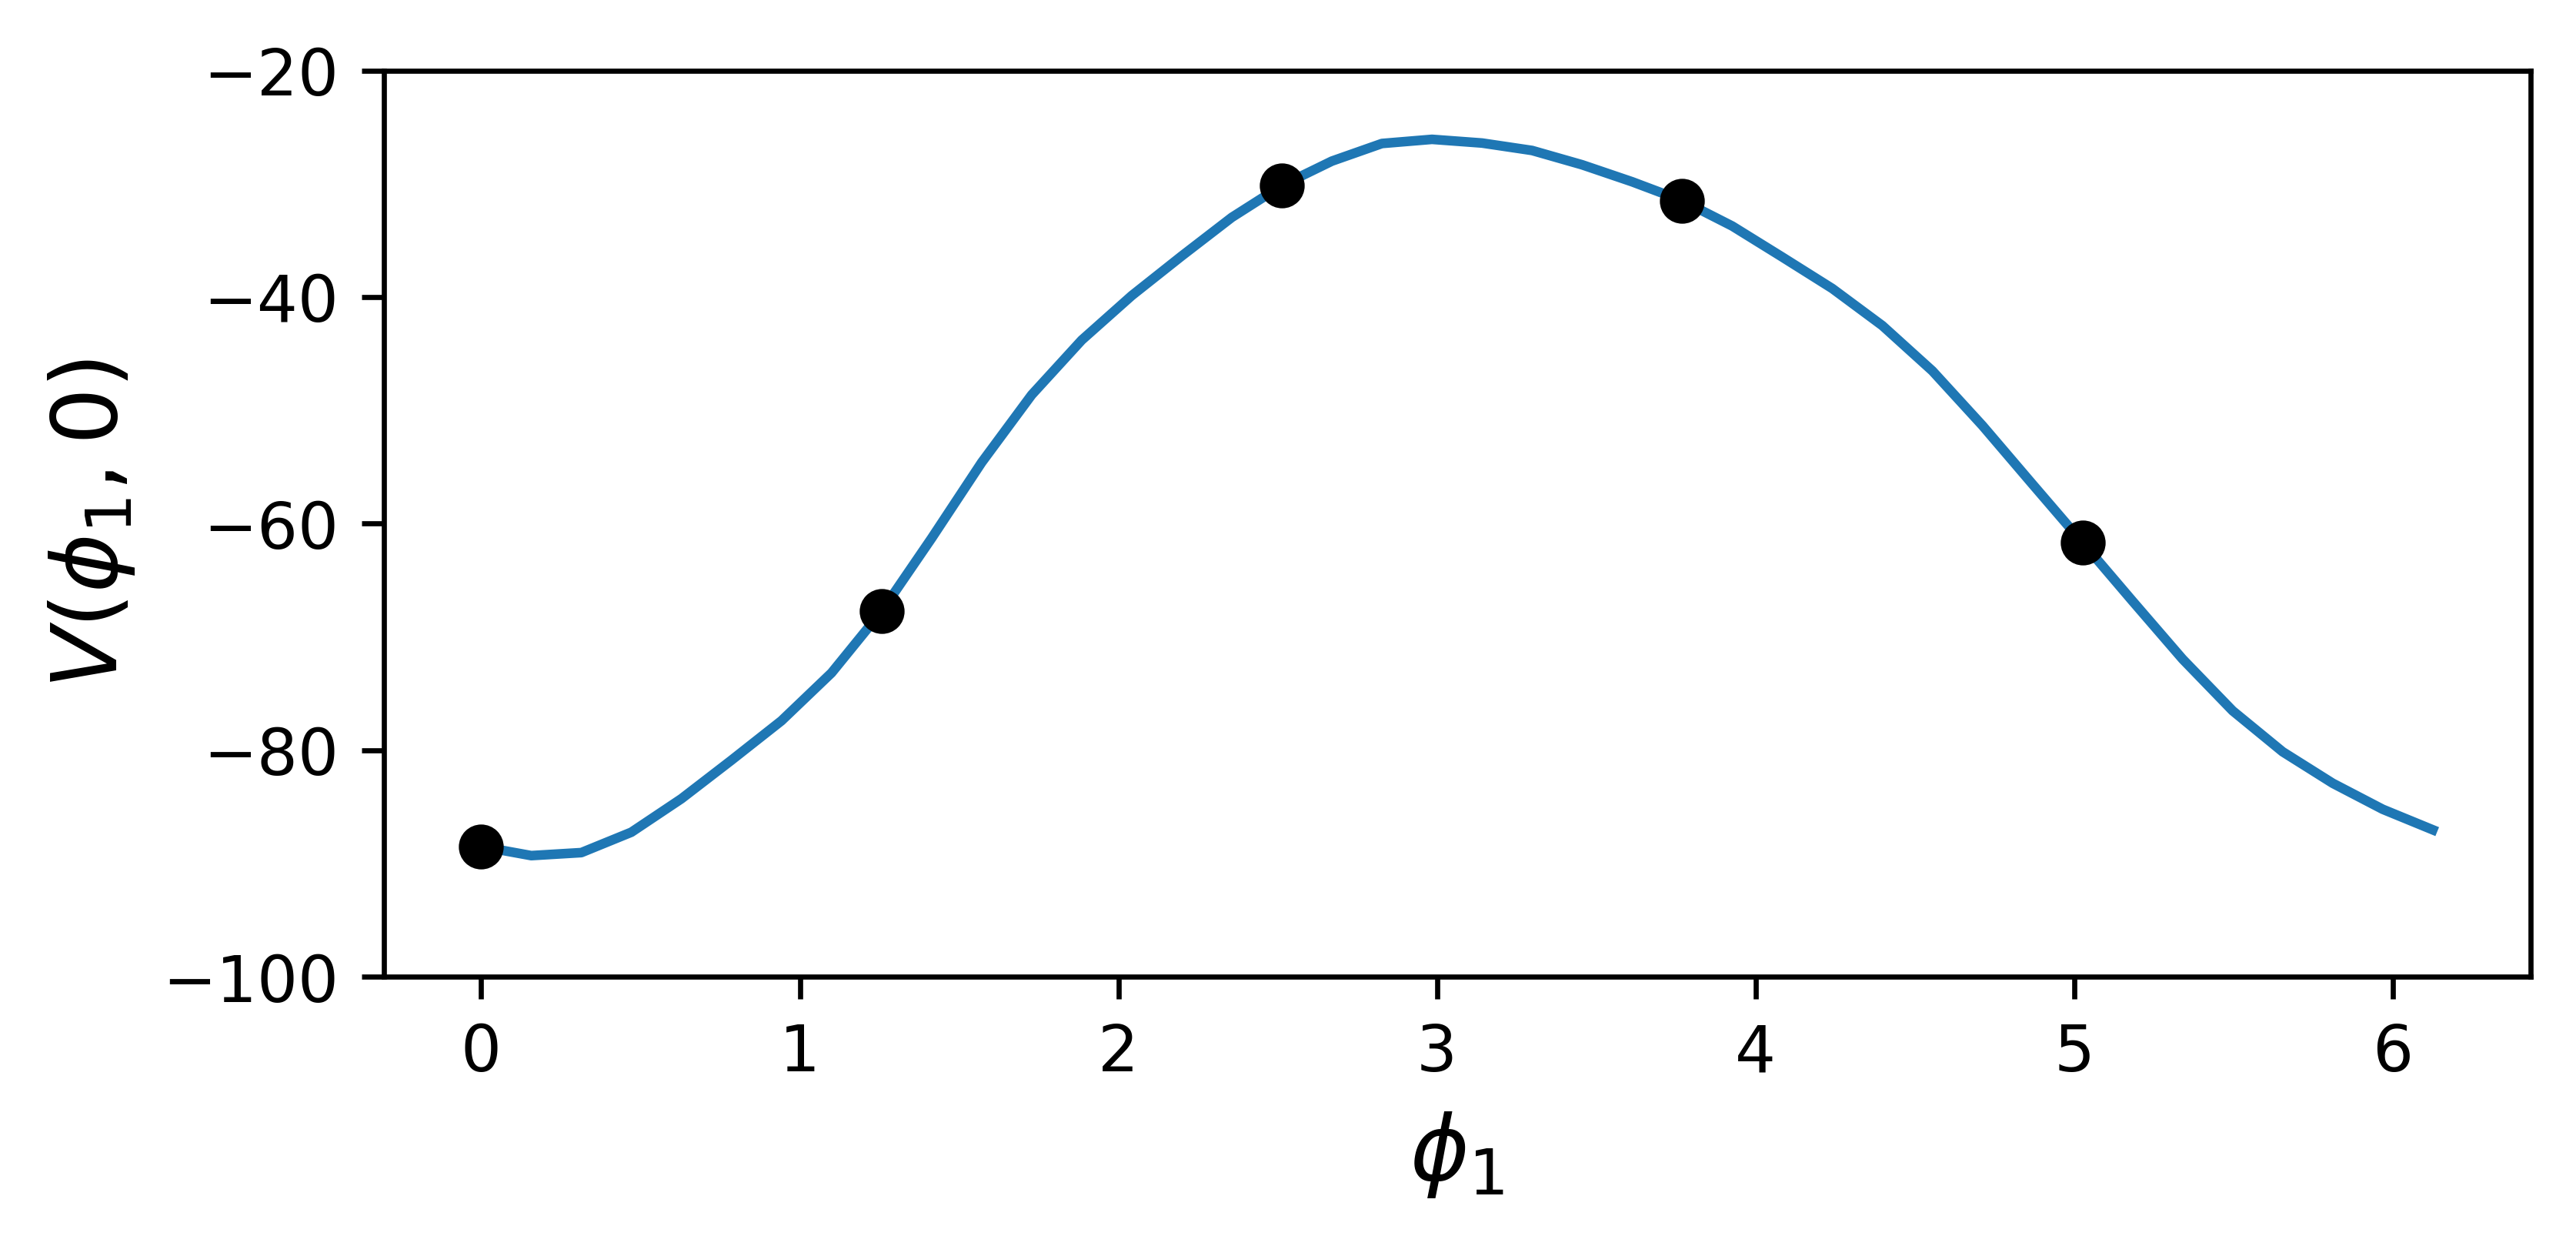

In [11]:
V_q = model.ode.V_net(cos_q_sin_q).detach().cpu().numpy()
markers_on = [0, 8, 16, 24, 32]
fig = plt.figure(figsize=[6, 2.6], dpi=DPI)
plt.plot(q1[:-1], V_q, marker = 'o', markevery=markers_on, markerfacecolor=(0,0,0,1), markeredgecolor=(0,0,0,1))
plt.xlabel(r"$\phi_1$", fontsize=14)
plt.ylabel(r"$V(\phi_1, 0)$", fontsize=14)
plt.ylim([-100, -20])

### plot 5 reconstruction images corresponding to the 5 black dots

In [12]:
ones = torch.ones_like(cos_q_sin_q[:, 0:1])
link1 = model.obs_net_1(ones)
link2 = model.obs_net_2(ones)

theta1 = model.get_theta_inv(cos_q_sin_q[:, 0], cos_q_sin_q[:, 2], 0, 0, bs=40)
link1_l = torch.sigmoid(model.link1_para)
x = link1_l * cos_q_sin_q[:, 2]
y = link1_l * cos_q_sin_q[:, 0]
theta2 = model.get_theta_inv(cos_q_sin_q[:, 1], cos_q_sin_q[:, 3], x, y, bs=40)

grid1 = F.affine_grid(theta1, torch.Size((40, 1, 64, 64)))
grid2 = F.affine_grid(theta2, torch.Size((40, 1, 64, 64)))

transf_link1 = F.grid_sample(link1.view(40, 1, 64, 64), grid1)
transf_link2 = F.grid_sample(link2.view(40, 1, 64, 64), grid2)
Xrec = torch.cat([transf_link1, transf_link2, torch.zeros_like(transf_link1)], dim=1)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


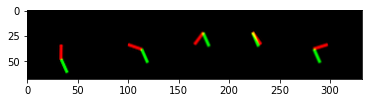

In [13]:
# for i in [0, 8, 16, 24, 32]:
#     fig = plt.figure()
#     plt.imshow(Xrec[i].permute(1,2,0).detach().cpu().numpy())
#     plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'acro_recon_phi1_{i}.png'), bbox_inches='tight')
grid = utils.make_grid(Xrec[0:40:8])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

## check how learned potential energy varies with $\phi_2$

In [14]:
q2 = np.linspace(0, 2*np.pi, 41)
q1 = np.linspace(0, 0, 41)
cos_q1 = np.cos(q1[:-1]) ; cos_q2 = np.cos(q2[:-1])
sin_q1 = np.sin(q1[:-1]) ; sin_q2 = np.sin(q2[:-1])
cos_q_sin_q = np.stack((cos_q1, cos_q2, sin_q1, sin_q2), axis=1)
cos_q_sin_q = torch.tensor(cos_q_sin_q, dtype=torch.float32)

(-100.0, 80.0)

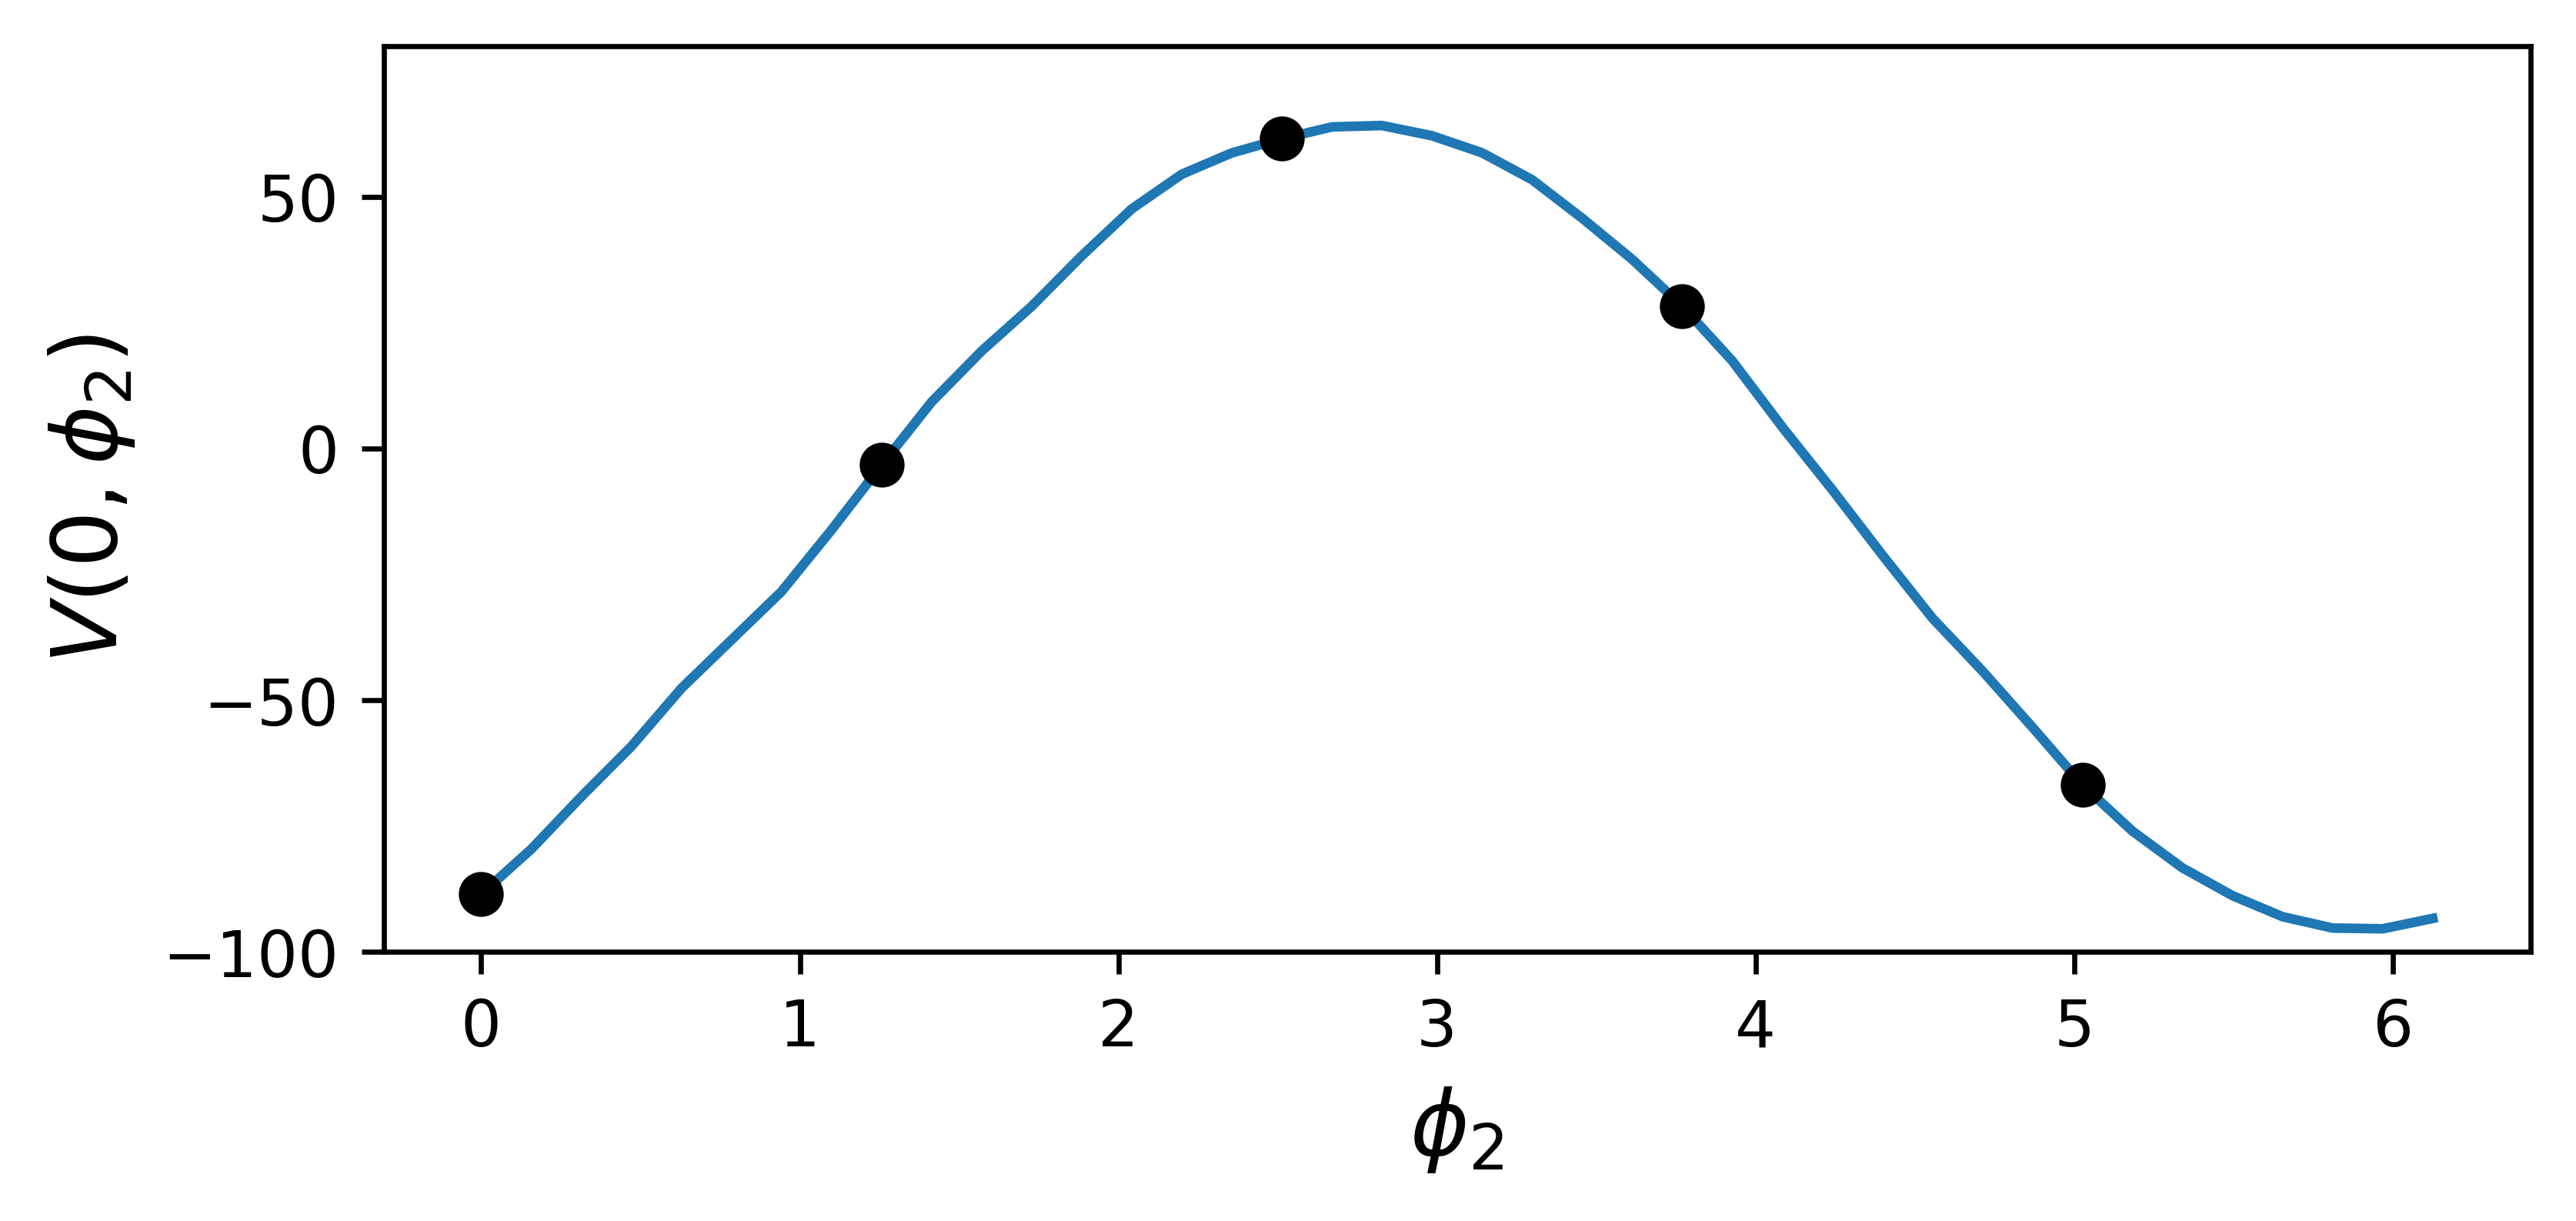

In [15]:
V_q = model.ode.V_net(cos_q_sin_q).detach().cpu().numpy()
markers_on = [0, 8, 16, 24, 32]
fig = plt.figure(figsize=[6, 2.6], dpi=DPI)
plt.plot(q2[:-1], V_q, marker = 'o', markevery=markers_on, markerfacecolor=(0,0,0,1), markeredgecolor=(0,0,0,1))
plt.xlabel(r"$\phi_2$", fontsize=14)
plt.ylabel(r"$V(0, \phi_2)$", fontsize=14)
plt.ylim([-100, 80])

### plot 5 reconstruction images corresponding to the 5 black dots

In [16]:
ones = torch.ones_like(cos_q_sin_q[:, 0:1])
link1 = model.obs_net_1(ones)
link2 = model.obs_net_2(ones)

theta1 = model.get_theta_inv(cos_q_sin_q[:, 0], cos_q_sin_q[:, 2], 0, 0, bs=40)
link1_l = torch.sigmoid(model.link1_para)
x = link1_l * cos_q_sin_q[:, 2]
y = link1_l * cos_q_sin_q[:, 0]
theta2 = model.get_theta_inv(cos_q_sin_q[:, 1], cos_q_sin_q[:, 3], x, y, bs=40)

grid1 = F.affine_grid(theta1, torch.Size((40, 1, 64, 64)))
grid2 = F.affine_grid(theta2, torch.Size((40, 1, 64, 64)))

transf_link1 = F.grid_sample(link1.view(40, 1, 64, 64), grid1)
transf_link2 = F.grid_sample(link2.view(40, 1, 64, 64), grid2)
Xrec = torch.cat([transf_link1, transf_link2, torch.zeros_like(transf_link1)], dim=1)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


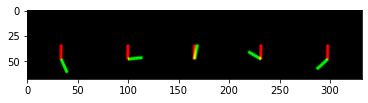

In [17]:
# for i in [0, 8, 16, 24, 32]:
#     fig = plt.figure()
#     plt.imshow(Xrec[i].permute(1,2,0).detach().cpu().numpy())
#     plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'acro_recon_phi1_{i}.png'), bbox_inches='tight')
grid = utils.make_grid(Xrec[0:40:8])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

# Control

In [18]:
import gym, myenv
import numpy as np
from gym import wrappers
env = gym.make('My_FA_Acrobot-v0')

# prepare model instance
model.hparams.solver = 'rk4'
model.bs = 1

# get a goal image
phi1_star = 3.14 ; phi2_star = 0.0
env.reset()
env.state = np.array([phi1_star, phi2_star, 0.0, 0.0], dtype=np.float32)
goal_frame = env.render(mode='rgb_array')
goal_frame = np.moveaxis(goal_frame, -1, -3) / 255.0
goal_frame = torch.tensor(goal_frame, dtype=torch.float32)
env.close()

# given a goal image, design controller
# first encode the goal image to goal coordinates
_, _, goal_phi1_n, goal_phi2_n, _, _ = model.encode(goal_frame.view(1, 3, 64, 64))

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
# set initial condition and perform energy based control

phi1_t0 = 0.0 ; phi2_t0 = 0.0
env.reset()
env.state = np.array([phi1_t0, phi2_t0, 0.0, 0.0], dtype=np.float32)
frame = env.render(mode='rgb_array')
frame =  np.moveaxis(frame, -1, -3) / 255.0
frames = [frame]
frame = torch.tensor(frame, dtype=torch.float32)

for i in range(100):
    _, _, phi1_n, phi2_n, _, _ = model.encode(frame.view(1, 3, 64, 64))
    if i == 0:
        prev_phi1_n = phi1_n; prev_phi2_n = phi2_n
    phi1_dot = model.angle_vel_est(prev_phi1_n, phi1_n, model.t_eval[1]-model.t_eval[0])
    phi2_dot = model.angle_vel_est(prev_phi2_n, phi2_n, model.t_eval[1]-model.t_eval[0])
    q_dot = torch.cat([phi1_dot, phi2_dot], dim=1) # bs, 2
    
    cos_q_sin_q = torch.cat([phi1_n[:, 0:1], phi2_n[:, 0:1], phi1_n[:, 1:2], phi2_n[:, 1:2]], dim=1)
    V_q = model.ode.V_net(cos_q_sin_q)
    dV = torch.autograd.grad(V_q, cos_q_sin_q)[0] # bs, 4
    dVdcos_q, dVdsin_q = torch.chunk(dV, 2, dim=1)
    dV_q = - dVdcos_q * cos_q_sin_q[:, 2:4] + dVdsin_q * cos_q_sin_q[:, 0:2] #, bs, 2
    g_q = model.ode.g_net(cos_q_sin_q)

    g_q_T = torch.transpose(g_q, 1, 2) # bs, 2, 2
    inv_g_g_T = torch.inverse(torch.matmul(g_q, g_q_T)) # bs, 2, 2
    g_T_inv_g_g_T = torch.matmul(g_q_T, inv_g_g_T) # bs, 2, 2

    energy_shaping = 1 * dV_q.T # 2， 1
    energy_shaping[0][0] += - 80 * (phi1_n[0, 1] * goal_phi1_n[0, 0] - phi1_n[0, 0] * goal_phi1_n[0, 1])
    energy_shaping[1][0] += - 40 * (phi2_n[0, 1] * goal_phi2_n[0, 0] - phi2_n[0, 0] * goal_phi2_n[0, 1])
    
#     energy_shaping = 4 * dV_q.T

    damping_injection = -12 * q_dot.T # 2, 1

    u = torch.matmul(g_T_inv_g_g_T, energy_shaping+damping_injection)
    u = u.squeeze().detach().cpu().numpy()
    
    env.step(u)

    frame = env.render(mode='rgb_array')
    frame =  np.moveaxis(frame, -1, -3) / 255.0
    frames.append(frame)
    frame = torch.tensor(frame, dtype=torch.float32)

    prev_phi1_n = phi1_n
    prev_phi2_n = phi2_n   
    
env.close()

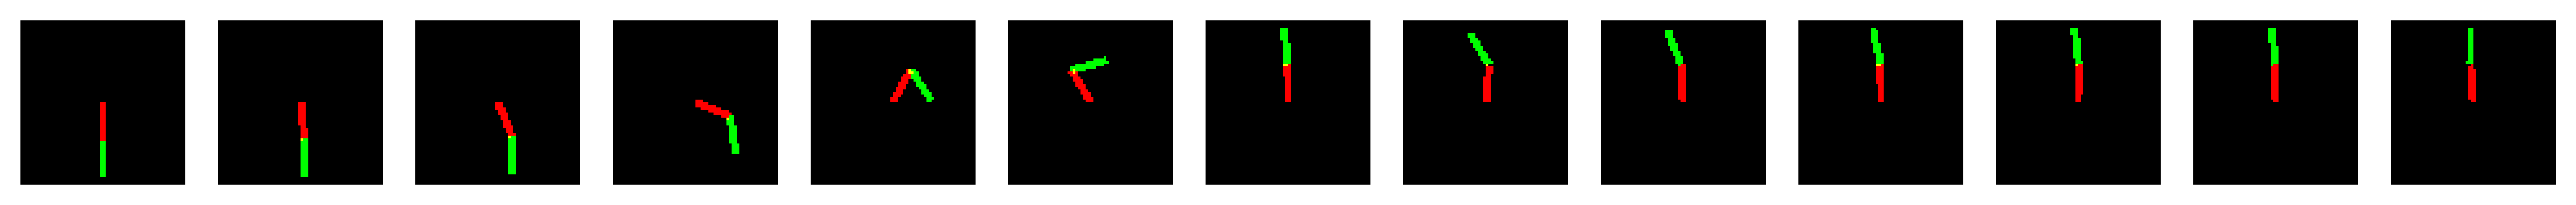

In [20]:
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(np.moveaxis(frames[i*8], -3, -1))
    plt.axis('off')
    
# fig.savefig(os.path.join(PARENT_DIR, 'figures', 'acro-ctrl.png'), bbox_inches='tight')

In [21]:
# new_frames = []
# for frame in frames:
#     new_frames.append(np.moveaxis(frame, -3, -1))

# import imageio
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'acro-ctrl.gif'), new_frames, duration=0.05)

control animation ![control sequence](../figures/acro-ctrl.gif)

In [22]:
model.hparams

"T_pred":                         4
"accumulate_grad_batches":        1
"amp_level":                      O2
"annealing":                      True
"auto_lr_find":                   False
"auto_scale_batch_size":          False
"auto_select_gpus":               False
"batch_size":                     256
"benchmark":                      False
"check_val_every_n_epoch":        1
"checkpoint_callback":            True
"default_root_dir":               None
"deterministic":                  False
"distributed_backend":            None
"early_stop_callback":            False
"fast_dev_run":                   False
"gradient_clip_val":              0
"homo_u":                         True
"learning_rate":                  0.001
"limit_test_batches":             1.0
"limit_train_batches":            1.0
"limit_val_batches":              1.0
"log_gpu_memory":                 None
"log_save_interval":              100
"logger":                         True
"max_epochs":                     30